운수업조사
-------------
https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1I100001&conn_path=I2

RNN 모델을 트레이닝 하기 위해서는 데이터 형태가 (샘플갯수, 타임스텝, 기록값) 이어야 합니다. 샘플 갯수는 각 지자체 별로 하나씩, 타임스텝은 년도별로 하나씩, 기록값은 종사자수나 결측치가 없는 어느 하나의 값을 정해 데이터를 정리한다면 RNN 모델에 적용시킬수가 있습니다.      



사용 API

In [1]:
from tensorflow import keras

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings   #  파이썬 경고메시지 제어
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = ['NanumGothic', 'sans-serif']

EDA 함수

In [ ]:
## EDA 함수

def df_check(df):
    ret_df = pd.DataFrame()
    feature_names=['missing count', 'u_count', 'min','max','mean', 'median', 'std']
    i = 0
    for s in df:
        s_list = []
        s_list.append(s)
#         s_list.append((df[s].isna().sum()*100)/len(df[s]))
        s_list.append(df[s].isna().sum())
        s_list.append(len(df[s].unique()))
        try:
            df[s].astype('float64')
            s_list.append(df[s].min())
            s_list.append(df[s].max())
            s_list.append(df[s].mean())
            s_list.append(df[s].median())
            s_list.append(df[s].std())
        except:
            for _ in range(5):
                s_list.append(np.NaN)
        finally:
            ret_df.insert(i, s, pd.Series(s_list[1:]))
            i = i+1
    x = ret_df.T
    x.columns = feature_names
    return x

데이터 정리부분

In [2]:
###전국단위##########################################################################
pd_data = pd.read_csv('시도별_산업별_총괄.csv', encoding='cp949', header=1)
pd_result = pd.DataFrame()

yr_list = [i for i in range(2007, 2020)]
del yr_list[3]

t = [2 + x for x in range(8)]
t = [0, 1] + t
col_names = pd_data.iloc[:, t].columns

offset = 0
for i, yr in enumerate(yr_list):
    col_list = [2 + x + offset for x in range(8)]
    col_list = [0, 1] + col_list
    offset = offset + 8
    x = pd_data.iloc[:, col_list]
    x.columns = col_names
    x.insert(0, 'year', pd.Series([yr] * 72))
    pd_result = pd.concat([pd_result, x], ignore_index=True, axis=0)
    
# print(pd_result)
print(pd_result.shape)

# pd_result
######################################################################################

(864, 11)


부산데이터만 확인  
부산에는 항공 운송업 X

In [ ]:
###부산광역시#########################################################################
filter_busan1 = pd_result['시도별'] == '부산광역시'

busan = pd_result[filter_busan1]
# print(busan.shape)
# print(busan.dtypes)

filter_busan2 = busan['산업별'] != '항공 운송업'
busan = busan[filter_busan2]
busan.iloc[:,3:] = busan.iloc[:,3:].astype('int64')


busan
# print(busan.dtypes)
######################################################################################

In [ ]:
sns.relplot(data=busan, x='year', y='급여액 (백만원)', col='산업별', kind='line')

In [ ]:
sns.scatterplot(data=busan, x='year', y='종사자수 (명)', hue='산업별')

In [ ]:
filter_busan3 = busan['산업별'] == '육상운송 및 파이프라인 운송업'
busan_overland = busan[filter_busan3]

sns.relplot(data=busan_overland, x='year', y='종사자수 (명)', kind='line')
# busan_overland


##array로 변환##
busan_overland_numpy = busan_overland['종사자수 (명)'].to_numpy()
# print(busan_overland_numpy)

#EDA
eda_busan = df_check(busan)
# print(eda_busan)
###'부산' 데이터만 간략하게##############################################################

전국 '육상운송 및 파이프라인 운송업' 부분만 정리

In [ ]:
# '전국', '서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시',
#       '울산광역시', '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도',
#       '경상북도', '경상남도', '제주특별자치도'

In [ ]:
# 전국 '육상운송 및 파이프라인 운송업' 분야만 ##################
# 결측치 확인 #

filterX = pd_result['산업별'] == '육상운송 및 파이프라인 운송업'

overland_data = pd_result[filterX]

filterY = overland_data['시도별'] == '세종특별시'

overland_data = overland_data[filterY]

# overland_data

# ======> 세종특별자치시 결측치 존재 2007, 2008, 2009, 2011

전국 '육상운송 및 파이프라인 운송업' ==> 종사자수

In [ ]:
# 전국 '육상운송 및 파이프라인 운송업' 분야에서 종사자수를 통한 조사 ##########
# 머신런닝(립런닝)에 사용할 데이터셋 제작 #

x = pd_result['시도별'].unique()

overland_data = []

for i in x:
    if i != '세종특별자치시' and i != '전국':
        filter1 = pd_result['시도별'] == i
        data = pd_result[filter1]

        filter2 = data['산업별'] == '육상운송 및 파이프라인 운송업'
        data_overland = data[filter2]
        data_overland.iloc[:,3:] = data_overland.iloc[:,3:].astype('int64')
        data_overland_numpy = data_overland['종사자수 (명)'].to_numpy()
#         print(data_overland_numpy)
        overland_data.append(data_overland_numpy)
    

# eda_all = df_check(overland_data)
# print(eda_all)
         
overland_data = np.array(overland_data)  # 기본데이터
# print('overland_data : \n', overland_data)

overland_data_standarded = (overland_data - overland_data.mean()/overland_data.std()) # 표준화한 데이터
# print(overland_data_standarded)

overland_data_normalization = (overland_data - overland_data.min())/(overland_data.max() - overland_data.min()) # 정규화한 데이터
# print(overland_data_standarded)
print(overland_data_normalization.shape)


# 정규화한 데이터
overland_data_x = overland_data_normalization[:, :-1]
overland_data_x = overland_data_x.reshape(16, 11, 1)

# 표준화한 데이터
# overland_data_x = overland_data_standarded[:, :-1]
# overland_data_x = overland_data_x.reshape(16, 11, 1)

# 기본데이터
# overland_data_x = overland_data[:, :-1]
# overland_data_x = overland_data_x.reshape(16, 11, 1)

print('\n overland_data_x : \n', overland_data_x)

# 정규화한 데이터
overland_data_y = overland_data_normalization[:,-1]

# 표준화한 데이터
# overland_data_y = overland_data_standarded[:,-1]

# 기본데이터
# overland_data_y = overland_data[:,-1]

print('\n overland_data_y : \n', overland_data_y)



# print(overland_data_x.shape)
# print(overland_data_y.shape)

# x train 16 11 1
# y train 16 1

In [ ]:
# 기본데이터
overland_data = np.array(overland_data)  

# 정규화한 데이터
overland_data_normalization = (overland_data - overland_data.min())/(overland_data.max() - overland_data.min()) 

# 입력 데이터
overland_data_x = overland_data_normalization[:, :-1]
overland_data_x = overland_data_x.reshape(16, 11, 1)

# 타켓 데이터
overland_data_y = overland_data_normalization[:,-1]


print('-'*5, '각 데이터 shape', '-'*5)
print('정규화된 데이터 shpae: ', overland_data_normalization.shape)
print('입력 데이터 x shpae: ', overland_data_x.shape)
print('타켓 데이터 y shpae: ', overland_data_y.shape)

print('-'*5, '각 데이터', '-'*5)
print('\n 정규화된 데이터 : \n',overland_data_standarded)
print('\n 입력 데이터 x : \n', overland_data_x)
print('\n 타켓 데이터 y : \n', overland_data_y)

In [ ]:
# _,axe = plt.subplots()
# axe.plot(overland_data[0])

In [ ]:
## RNN모델 적용 ##
model1 = keras.Sequential([
    keras.layers.SimpleRNN(16, input_shape=(None, 1))
])

model1.compile(optimizer='adam', loss='mse', metrics='mae')
model1.summary()
hist = model1.fit(overland_data_x, overland_data_y, epochs=1000)
print(model1.evaluate(overland_data_x, overland_data_y))


In [ ]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist.history['loss'])

_, axe = plt.subplots()
axe.plot(hist.history['mae'])

In [ ]:
## RNN모델 적용 ## ==> Dense 적용
model2 = keras.Sequential([
    keras.layers.SimpleRNN(16, input_shape=(None, 1)),
    keras.layers.Dense(1)
])

model2.compile(optimizer='adam', loss='mse', metrics='mae')
model2.summary()
hist2 = model2.fit(overland_data_x, overland_data_y, epochs=1000)
print(model2.evaluate(overland_data_x, overland_data_y))

In [ ]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist2.history['loss'])

_, axe = plt.subplots()
axe.plot(hist2.history['mae'])

In [ ]:
overland_data_predict = model2.predict(overland_data_x[1].reshape(1, 11, 1))
print(overland_data_predict)
print(overland_data_predict.shape)

_, axe = plt.subplots()
axe.plot(overland_data_x[1])
axe.scatter([11], overland_data_y[1], c='r')
axe.scatter([11], overland_data_predict, c='b')

# 약간 안맞음

In [ ]:
## RNN모델 적용 ## ==> RNN 레이어 3단 적용
model3 = keras.Sequential([
    keras.layers.SimpleRNN(16, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model3.compile(optimizer='adam', loss='mse', metrics='mae')
model3.summary()
hist3 = model3.fit(overland_data_x, overland_data_y, epochs=1000)
print(model3.evaluate(overland_data_x, overland_data_y))

In [ ]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist3.history['loss'])

_, axe = plt.subplots()
axe.plot(hist3.history['mae'])

In [ ]:
overland_data_predict = model3.predict(overland_data_x[1].reshape(1, 11, 1))
print(overland_data_predict)

_, axe = plt.subplots()
axe.plot(overland_data_x[1])
axe.scatter([11], overland_data_y[1], c='r')
axe.scatter([11], overland_data_predict, c='b')

# 맞음

전국 '육상운송 및 파이프라인 운송업' ==> 급여액

In [ ]:
# 전국 '육상운송 및 파이프라인 운송업' 분야에서 급여액를 통한 조사 ##########
# 머신런닝(립런닝)에 사용할 데이터셋 제작 #

x = pd_result['시도별'].unique()

overland_salary_data = []

for i in x:
    if i != '세종특별자치시' and i != '전국':
        filter1 = pd_result['시도별'] == i
        data = pd_result[filter1]

        filter2 = data['산업별'] == '육상운송 및 파이프라인 운송업'
        data_overland = data[filter2]
        data_overland.iloc[:,3:] = data_overland.iloc[:,3:].astype('int64')
        data_overland_numpy = data_overland['급여액 (백만원)'].to_numpy()
#         print(data_overland_numpy)
        overland_salary_data.append(data_overland_numpy)
    

overland_salary_data = np.array(overland_salary_data)  # 기본데이터
print('overland_salary_data : \n', overland_salary_data)

overland_salary_data_standarded = (overland_salary_data - overland_salary_data.mean()/overland_salary_data.std()) # 표준화한 데이터
# print(overland_salary_data_standarded)

overland_salary_data_normalization = (overland_salary_data - overland_salary_data.min())/(overland_salary_data.max() - overland_salary_data.min()) # 정규화한 데이터
# print(overland_salary_data_normalization) 


# 정규화한 데이터
overland_salary_data_x = overland_salary_data_normalization[:, :-1]
overland_salary_data_x = overland_salary_data_x.reshape(16, 11, 1)

# 표준화한 데이터
# overland_salary_data_x = overland_salary_data_standarded[:, :-1]
# overland_salary_data_x = overland_salary_data_x.reshape(16, 11, 1)

# 기본데이터
# overland_salary_data_x = overland_salary_data[:, :-1]
# overland_salary_data_x = overland_data_x.reshape(16, 11, 1)
print('\n overland_salary_data_x : \n', overland_salary_data_x)


# 정규화한 데이터
overland_salary_data_y = overland_salary_data_normalization[:,-1]

# 표준화한 데이터
# overland_salary_data_y = overland_salary_data_standarded[:,-1]

# 기본데이터
# overland_salary_data_y = overland_salary_data[:,-1]
print('\n overland_salary_data_y : \n', overland_salary_data_y)

print(overland_salary_data_x.shape)
print(overland_salary_data_y.shape)

In [ ]:
## RNN모델 적용 ##
model4 = keras.Sequential([
    keras.layers.SimpleRNN(16, input_shape=(None, 1))
])

model4.compile(optimizer='adam', loss='mse', metrics='mae')
model4.summary()
hist4 = model4.fit(overland_salary_data_x, overland_salary_data_y, epochs=1000)
print(model4.evaluate(overland_salary_data_x, overland_salary_data_y))

In [ ]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist4.history['loss'])

_, axe = plt.subplots()
axe.plot(hist4.history['mae'])

In [ ]:
## RNN모델 적용 ## ==> RNN 레이어 3단 적용
model5 = keras.Sequential([
    keras.layers.SimpleRNN(16, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model5.compile(optimizer='adam', loss='mse', metrics='mae')
model5.summary()
hist5 = model5.fit(overland_salary_data_x, overland_salary_data_y, epochs=1000)
print(model5.evaluate(overland_salary_data_x, overland_salary_data_y))

In [ ]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist5.history['loss'])

_, axe = plt.subplots()
axe.plot(hist5.history['mae'])

In [ ]:
overland_salary_data_predict = model5.predict(overland_salary_data_x[1].reshape(1, 11, 1))
print(overland_salary_data_predict)

_, axe = plt.subplots()
axe.plot(overland_salary_data_x[1])
axe.scatter([11], overland_salary_data_y[1], c='r')
axe.scatter([11], overland_salary_data_predict, c='b')

# 조금 차이가 있음.

In [ ]:
## RNN모델 적용 ## ==> Dense 적용
model6 = keras.Sequential([
    keras.layers.SimpleRNN(16, input_shape=(None, 1)),
    keras.layers.Dense(1)
])

model6.compile(optimizer='adam', loss='mse', metrics='mae')
model6.summary()
hist6 = model6.fit(overland_salary_data_x, overland_salary_data_y, epochs=1000)
print(model6.evaluate(overland_salary_data_x, overland_salary_data_y))

In [ ]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist6.history['loss'])

_, axe = plt.subplots()
axe.plot(hist6.history['mae'])

In [ ]:
overland_salary_data_predict = model6.predict(overland_salary_data_x[1].reshape(1, 11, 1))
print(overland_salary_data_predict)

_, axe = plt.subplots()
axe.plot(overland_salary_data_x[1])
axe.scatter([11], overland_salary_data_y[1], c='r')
axe.scatter([11], overland_salary_data_predict, c='b')

# 얼추 비슷함.

전국 '육상운송 및 파이프라인 운송업' ==> 매출액

In [ ]:
# 전국 '육상운송 및 파이프라인 운송업' 분야에서 매출액 (백만원)를 통한 조사 ##########
# 머신런닝(립런닝)에 사용할 데이터셋 제작 #

x = pd_result['시도별'].unique()

overland_sales_data = []

for i in x:
    if i != '세종특별자치시' and i != '전국':
        filter1 = pd_result['시도별'] == i
        data = pd_result[filter1]

        filter2 = data['산업별'] == '육상운송 및 파이프라인 운송업'
        data_overland = data[filter2]
        data_overland.iloc[:,3:] = data_overland.iloc[:,3:].astype('int64')
        data_overland_numpy = data_overland['매출액 (백만원)'].to_numpy()
#         print(data_overland_numpy)
        overland_sales_data.append(data_overland_numpy)
    

overland_sales_data = np.array(overland_sales_data)  # 기본데이터
print('overland_sales_data : \n', overland_sales_data)

overland_sales_data_standarded = (overland_sales_data - overland_sales_data.mean()/overland_sales_data.std()) # 표준화한 데이터
# print(overland_sales_data_standarded)

overland_sales_data_normalization = (overland_sales_data - overland_sales_data.min())/(overland_sales_data.max() - overland_sales_data.min()) # 정규화한 데이터
# print(overland_sales_data_normalization) 


# 정규화한 데이터
overland_sales_data_x = overland_sales_data_normalization[:, :-1]
overland_sales_data_x = overland_sales_data_x.reshape(16, 11, 1)

# 표준화한 데이터
# overland_sales_data_x = overland_sales_data_standarded[:, :-1]
# overland_sales_data_x = overland_salary_data_x.reshape(16, 11, 1)

# 기본데이터
# overland_sales_data_x = overland_sales_data[:, :-1]
# overland_sales_data_x = overland_data_x.reshape(16, 11, 1)
print('\n overland_sales_data_x : \n', overland_sales_data_x)


# 정규화한 데이터
overland_sales_data_y = overland_sales_data_normalization[:,-1]

# 표준화한 데이터
# overland_sales_data_y = overland_sales_data_standarded[:,-1]

# 기본데이터
# overland_sales_data_y = overland_sales_data[:,-1]
print('\n overland_sales_data_y : \n', overland_sales_data_y)

print(overland_sales_data_x.shape)
print(overland_sales_data_y.shape)

In [ ]:
## RNN모델 적용 ## ==> RNN 레이어 3단 적용
model7 = keras.Sequential([
    keras.layers.SimpleRNN(16, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model7.compile(optimizer='adam', loss='mse', metrics='mae')
model7.summary()
hist7 = model7.fit(overland_sales_data_x, overland_sales_data_y, epochs=1000)
print(model7.evaluate(overland_sales_data_x, overland_sales_data_y))

In [ ]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist7.history['loss'])

_, axe = plt.subplots()
axe.plot(hist7.history['mae'])

In [ ]:
overland_sales_data_predict = model7.predict(overland_sales_data_x[1].reshape(1, 11, 1))
print(overland_sales_data_predict)

_, axe = plt.subplots()
axe.plot(overland_sales_data_x[1])
axe.scatter([11], overland_sales_data_y[1], c='r')
axe.scatter([11], overland_sales_data_predict, c='b')

In [ ]:
## RNN모델 적용 ## ==> Dense 적용
model8 = keras.Sequential([
    keras.layers.SimpleRNN(16, input_shape=(None, 1)),
    keras.layers.Dense(1)
])

model8.compile(optimizer='adam', loss='mse', metrics='mae')
model8.summary()
hist8 = model8.fit(overland_sales_data_x, overland_sales_data_y, epochs=1000)
print(model8.evaluate(overland_sales_data_x, overland_sales_data_y))

In [ ]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist8.history['loss'])

_, axe = plt.subplots()
axe.plot(hist8.history['mae'])

In [ ]:
overland_sales_data_predict = model8.predict(overland_sales_data_x[1].reshape(1, 11, 1))
print(overland_sales_data_predict)

_, axe = plt.subplots()
axe.plot(overland_sales_data_x[1])
axe.scatter([11], overland_sales_data_y[1], c='r')
axe.scatter([11], overland_sales_data_predict, c='b')

2010 년도 데이터 추측  
2019년 ~ 2011년도 까지의 역순으로 이용하여 예측

In [3]:
## 2010년도 데이터 예측해보기 ##########################################

# pd_result['year'].dtype


# filter_year1 = pd_result['year'] != 2007
# overland_2010_search = pd_result[filter_year1]

# filter_year2 = pd_result['year'] != 2008
# overland_2010_search = overland_2010_search[filter_year2]

# filter_year3 = pd_result['year'] != 2009
# overland_2010_search = overland_2010_search[filter_year3]

for i in range(2007, 2010):
    if i == 2007:
        filter_year = pd_result['year'] != i
        overland_2010_search = pd_result[filter_year]
    else:
        filter_year = pd_result['year'] != i
        overland_2010_search = overland_2010_search[filter_year]
        
# print(overland_2010_search.shape)
# print(overland_2010_search.loc[::-1].shape)

overland_2010_search = overland_2010_search.loc[::-1]

v = overland_2010_search['산업별'] == '육상운송 및 파이프라인 운송업'
overland_2010_search[v]

,year,시도별,산업별,기업체수 (개),종사자수 (명),급여액 (백만원),운송수단 및 창고수 (수),매출액 (백만원),영업비용 (백만원),부가가치 (백만원),유형자산 (백만원)
860,2019,제주특별자치도,육상운송 및 파이프라인 운송업,6089,12421,166020,11360,631455,518550,352295,409677
856,2019,경상남도,육상운송 및 파이프라인 운송업,18939,40606,587034,34806,2144435,1874075,1154324,940684
852,2019,경상북도,육상운송 및 파이프라인 운송업,16902,36825,612678,32950,2118141,1812949,1172375,1018571
848,2019,전라남도,육상운송 및 파이프라인 운송업,9062,28052,599585,24515,1862420,1742706,936461,900410
844,2019,전라북도,육상운송 및 파이프라인 운송업,12344,27056,421297,24667,1515888,1264536,827835,669659
...,...,...,...,...,...,...,...,...,...,...,...
232,2011,인천광역시,육상운송 및 파이프라인 운송업,19126,54060,928001,46245,4142832,3881732,1674835,3157145
228,2011,대구광역시,육상운송 및 파이프라인 운송업,19546,48035,713529,42135,2369049,2272460,1176128,3851309
224,2011,부산광역시,육상운송 및 파이프라인 운송업,25292,72619,1247244,59100,4670504,4300544,2318945,4696239
220,2011,서울특별시,육상운송 및 파이프라인 운송업,86093,274439,5557696,201732,18454254,16964359,9449061,16771810


In [ ]:
x = overland_2010_search['시도별'].unique()

overland_2010 = []

for i in x:
    if i != '세종특별자치시' and i != '전국':
        filter1 = overland_2010_search['시도별'] == i
        data = overland_2010_search[filter1]

        filter2 = data['산업별'] == '육상운송 및 파이프라인 운송업'
        data_overland = data[filter2]
        data_overland.iloc[:,3:] = data_overland.iloc[:,3:].astype('int64')
        data_overland_numpy = data_overland['종사자수 (명)'].to_numpy()
#         print(data_overland_numpy)
        overland_2010.append(data_overland_numpy)
         
overland_2010 = np.array(overland_2010)
print('overland_2010 : \n', overland_2010)

overland_2010_normalization = (overland_2010 - overland_2010.min())/(overland_2010.max() - overland_2010.min()) # 정규화한 데이터
print(overland_2010_normalization) 
print(overland_2010_normalization.shape)

# 정규화한 데이터
overland_2010_x = overland_2010_normalization[:, :-1]
overland_2010_x = overland_2010_x.reshape(16, 8, 1)

print('\n overland_2010_x : \n', overland_2010_x)

# 정규화한 데이터
overland_2010_y = overland_2010_normalization[:,-1]

print('\n overland_2010_y : \n', overland_2010_y)


In [ ]:
## RNN모델 적용 ## ==> RNN 레이어 3단 적용
model9 = keras.Sequential([
    keras.layers.SimpleRNN(16, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model9.compile(optimizer='adam', loss='mse', metrics='mae')
model9.summary()
hist9 = model9.fit(overland_2010_x, overland_2010_y, epochs=1000)
print(model9.evaluate(overland_2010_x, overland_2010_y))

In [ ]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist9.history['loss'])

_, axe = plt.subplots()
axe.plot(hist9.history['mae'])

In [ ]:
overland_2010_predict = model9.predict(overland_2010_x[1].reshape(1, 8, 1))
print(overland_2010_predict)

_, axe = plt.subplots()
axe.plot(overland_2010_x[1])
axe.scatter([8], overland_2010_y[1], c='r')
axe.scatter([8], overland_2010_predict, c='b')

In [ ]:
## RNN모델 적용 ## ==> Dense 적용
model10 = keras.Sequential([
    keras.layers.SimpleRNN(16, input_shape=(None, 1)),
    keras.layers.Dense(1)
])

model10.compile(optimizer='adam', loss='mse', metrics='mae')
model10.summary()
hist10 = model10.fit(overland_2010_x, overland_2010_y, epochs=1000)
print(model10.evaluate(overland_2010_x, overland_2010_y))

In [ ]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist10.history['loss'])

_, axe = plt.subplots()
axe.plot(hist10.history['mae'])

In [ ]:
overland_2010_predict = model10.predict(overland_2010_x[1].reshape(1, 8, 1))
print(overland_2010_predict)

_, axe = plt.subplots()
axe.plot(overland_2010_x[1])
axe.scatter([8], overland_2010_y[1], c='r')
axe.scatter([8], overland_2010_predict, c='b')

In [ ]:
sample_n = 6  # 샘플 인덱스 변수화

overland_2010_predict = model10.predict(overland_2010_x[sample_n].reshape(1, 8, 1))
print(overland_2010_predict)

_, axe = plt.subplots()
axe.plot(overland_2010_x[sample_n])
axe.scatter([8], overland_2010_y[sample_n], c='r')
axe.scatter([8], overland_2010_predict, c='b')

In [5]:
x = overland_2010_search['시도별'].unique()

overland_2010 = []

for i in x:
    if i != '세종특별자치시' and i != '전국':
        filter1 = overland_2010_search['시도별'] == i
        data = overland_2010_search[filter1]

        filter2 = data['산업별'] == '육상운송 및 파이프라인 운송업'
        data_overland = data[filter2]
        data_overland.iloc[:,3:] = data_overland.iloc[:,3:].astype('int64')
        data_overland_numpy = data_overland['급여액 (백만원)'].to_numpy()
#         print(data_overland_numpy)
        overland_2010.append(data_overland_numpy)
         
overland_2010 = np.array(overland_2010)
print('overland_2010 : \n', overland_2010)

overland_2010_normalization = (overland_2010 - overland_2010.min())/(overland_2010.max() - overland_2010.min()) # 정규화한 데이터
print(overland_2010_normalization) 
print(overland_2010_normalization.shape)

# 정규화한 데이터
overland_2010_x = overland_2010_normalization[:, :-1]
overland_2010_x = overland_2010_x.reshape(16, 8, 1)

print('\n overland_2010_x : \n', overland_2010_x)

# 정규화한 데이터
overland_2010_y = overland_2010_normalization[:,-1]

print('\n overland_2010_y : \n', overland_2010_y)


overland_2010 : 
 [[ 166020  152726  116234   94517   84458   85585   80465   85505   82097]
 [ 587034  570489  593133  542607  559653  477569  497435  532854  459493]
 [ 612678  517077  533438  473855  448407  540503  429789  443556  393620]
 [ 599585  585323  498351  465193  393205  345256  363961  461854  258810]
 [ 421297  409263  393921  438482  379923  399354  354216  355052  396059]
 [ 536626  469302  511931  524072  463665  334488  329916  378149  457590]
 [ 386949  328412  316714  292329  274565  285543  316906  284417  269258]
 [ 274852  282450  232501  241939  229744  223394  228729  204796  208955]
 [3499616 3218059 2714920 2623088 2407233 2282782 2541821 2622511 1999413]
 [ 414910  414600  383996  327113  319593  250513  233658  321181  228543]
 [2492321 2455417 2211959 2210662 2137313 1962813 2205147 2155148 2465776]
 [ 449421  403477  499893  497365  475126  350400  363413  355538  312716]
 [ 887824  849592  844113  775846  790584  782142  801913  754962  928001]
 [ 8206

In [6]:
## RNN모델 적용 ## ==> RNN 레이어 3단 적용
model11 = keras.Sequential([
    keras.layers.SimpleRNN(16, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model11.compile(optimizer='adam', loss='mse', metrics='mae')
model11.summary()
hist11 = model11.fit(overland_2010_x, overland_2010_y, epochs=1000)
print(model11.evaluate(overland_2010_x, overland_2010_y))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 16)          288       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 8)           200       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1)                 10        
                                                                 
Total params: 498
Trainable params: 498
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 7s 7s/step - loss: 0.1251 - mae: 0.2157
Epoch 2/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.1048 - mae: 0.1842
Epoch 3/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0861 - mae: 0.1541
Epoch 4/1000
1/1 [========================

1/1 [==============================] - 0s 21ms/step - loss: 0.0013 - mae: 0.0254
Epoch 79/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0013 - mae: 0.0252
Epoch 80/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0013 - mae: 0.0249
Epoch 81/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0013 - mae: 0.0246
Epoch 82/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0012 - mae: 0.0243
Epoch 83/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0012 - mae: 0.0241
Epoch 84/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0012 - mae: 0.0240
Epoch 85/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0012 - mae: 0.0239
Epoch 86/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0012 - mae: 0.0238
Epoch 87/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0011 - mae: 0.0237
Epoch 88/1000
1/1 [==============================] - 0s 21ms/ste

Epoch 161/1000
1/1 [==============================] - 0s 23ms/step - loss: 4.9407e-04 - mae: 0.0174
Epoch 162/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.9152e-04 - mae: 0.0173
Epoch 163/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8905e-04 - mae: 0.0173
Epoch 164/1000
1/1 [==============================] - 0s 22ms/step - loss: 4.8664e-04 - mae: 0.0172
Epoch 165/1000
1/1 [==============================] - 0s 22ms/step - loss: 4.8430e-04 - mae: 0.0172
Epoch 166/1000
1/1 [==============================] - 0s 22ms/step - loss: 4.8202e-04 - mae: 0.0171
Epoch 167/1000
1/1 [==============================] - 0s 21ms/step - loss: 4.7980e-04 - mae: 0.0171
Epoch 168/1000
1/1 [==============================] - 0s 23ms/step - loss: 4.7764e-04 - mae: 0.0171
Epoch 169/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.7554e-04 - mae: 0.0170
Epoch 170/1000
1/1 [==============================] - 0s 20ms/step - loss: 4.7348e-04 - mae: 0.0170


1/1 [==============================] - 0s 21ms/step - loss: 3.9337e-04 - mae: 0.0151
Epoch 243/1000
1/1 [==============================] - 0s 23ms/step - loss: 3.9266e-04 - mae: 0.0151
Epoch 244/1000
1/1 [==============================] - 0s 21ms/step - loss: 3.9194e-04 - mae: 0.0151
Epoch 245/1000
1/1 [==============================] - 0s 23ms/step - loss: 3.9123e-04 - mae: 0.0151
Epoch 246/1000
1/1 [==============================] - 0s 23ms/step - loss: 3.9053e-04 - mae: 0.0151
Epoch 247/1000
1/1 [==============================] - 0s 22ms/step - loss: 3.8982e-04 - mae: 0.0150
Epoch 248/1000
1/1 [==============================] - 0s 23ms/step - loss: 3.8913e-04 - mae: 0.0150
Epoch 249/1000
1/1 [==============================] - 0s 23ms/step - loss: 3.8843e-04 - mae: 0.0150
Epoch 250/1000
1/1 [==============================] - 0s 22ms/step - loss: 3.8774e-04 - mae: 0.0150
Epoch 251/1000
1/1 [==============================] - 0s 23ms/step - loss: 3.8706e-04 - mae: 0.0150
Epoch 252/1000


1/1 [==============================] - 0s 15ms/step - loss: 3.4376e-04 - mae: 0.0141
Epoch 325/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.4324e-04 - mae: 0.0141
Epoch 326/1000
1/1 [==============================] - 0s 20ms/step - loss: 3.4273e-04 - mae: 0.0141
Epoch 327/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.4221e-04 - mae: 0.0141
Epoch 328/1000
1/1 [==============================] - 0s 20ms/step - loss: 3.4170e-04 - mae: 0.0141
Epoch 329/1000
1/1 [==============================] - 0s 17ms/step - loss: 3.4119e-04 - mae: 0.0141
Epoch 330/1000
1/1 [==============================] - 0s 16ms/step - loss: 3.4068e-04 - mae: 0.0140
Epoch 331/1000
1/1 [==============================] - 0s 22ms/step - loss: 3.4017e-04 - mae: 0.0140
Epoch 332/1000
1/1 [==============================] - 0s 24ms/step - loss: 3.3966e-04 - mae: 0.0140
Epoch 333/1000
1/1 [==============================] - 0s 23ms/step - loss: 3.3916e-04 - mae: 0.0140
Epoch 334/1000


1/1 [==============================] - 0s 21ms/step - loss: 3.0653e-04 - mae: 0.0133
Epoch 407/1000
1/1 [==============================] - 0s 22ms/step - loss: 3.0614e-04 - mae: 0.0133
Epoch 408/1000
1/1 [==============================] - 0s 21ms/step - loss: 3.0574e-04 - mae: 0.0133
Epoch 409/1000
1/1 [==============================] - 0s 22ms/step - loss: 3.0535e-04 - mae: 0.0132
Epoch 410/1000
1/1 [==============================] - 0s 19ms/step - loss: 3.0496e-04 - mae: 0.0132
Epoch 411/1000
1/1 [==============================] - 0s 21ms/step - loss: 3.0457e-04 - mae: 0.0132
Epoch 412/1000
1/1 [==============================] - 0s 21ms/step - loss: 3.0418e-04 - mae: 0.0132
Epoch 413/1000
1/1 [==============================] - 0s 23ms/step - loss: 3.0379e-04 - mae: 0.0132
Epoch 414/1000
1/1 [==============================] - 0s 22ms/step - loss: 3.0340e-04 - mae: 0.0132
Epoch 415/1000
1/1 [==============================] - 0s 21ms/step - loss: 3.0301e-04 - mae: 0.0132
Epoch 416/1000


1/1 [==============================] - 0s 20ms/step - loss: 2.7763e-04 - mae: 0.0127
Epoch 489/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.7731e-04 - mae: 0.0126
Epoch 490/1000
1/1 [==============================] - 0s 21ms/step - loss: 2.7700e-04 - mae: 0.0126
Epoch 491/1000
1/1 [==============================] - 0s 21ms/step - loss: 2.7669e-04 - mae: 0.0126
Epoch 492/1000
1/1 [==============================] - 0s 23ms/step - loss: 2.7637e-04 - mae: 0.0126
Epoch 493/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.7606e-04 - mae: 0.0126
Epoch 494/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.7575e-04 - mae: 0.0126
Epoch 495/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.7544e-04 - mae: 0.0126
Epoch 496/1000
1/1 [==============================] - 0s 21ms/step - loss: 2.7513e-04 - mae: 0.0126
Epoch 497/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.7482e-04 - mae: 0.0126
Epoch 498/1000


1/1 [==============================] - 0s 21ms/step - loss: 2.5396e-04 - mae: 0.0121
Epoch 571/1000
1/1 [==============================] - 0s 21ms/step - loss: 2.5369e-04 - mae: 0.0121
Epoch 572/1000
1/1 [==============================] - 0s 19ms/step - loss: 2.5343e-04 - mae: 0.0121
Epoch 573/1000
1/1 [==============================] - 0s 19ms/step - loss: 2.5316e-04 - mae: 0.0121
Epoch 574/1000
1/1 [==============================] - 0s 23ms/step - loss: 2.5290e-04 - mae: 0.0121
Epoch 575/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.5263e-04 - mae: 0.0121
Epoch 576/1000
1/1 [==============================] - 0s 24ms/step - loss: 2.5237e-04 - mae: 0.0121
Epoch 577/1000
1/1 [==============================] - 0s 25ms/step - loss: 2.5210e-04 - mae: 0.0121
Epoch 578/1000
1/1 [==============================] - 0s 23ms/step - loss: 2.5184e-04 - mae: 0.0121
Epoch 579/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.5158e-04 - mae: 0.0121
Epoch 580/1000


1/1 [==============================] - 0s 23ms/step - loss: 2.3329e-04 - mae: 0.0117
Epoch 653/1000
1/1 [==============================] - 0s 23ms/step - loss: 2.3305e-04 - mae: 0.0117
Epoch 654/1000
1/1 [==============================] - 0s 24ms/step - loss: 2.3281e-04 - mae: 0.0116
Epoch 655/1000
1/1 [==============================] - 0s 29ms/step - loss: 2.3257e-04 - mae: 0.0116
Epoch 656/1000
1/1 [==============================] - 0s 20ms/step - loss: 2.3233e-04 - mae: 0.0116
Epoch 657/1000
1/1 [==============================] - 0s 21ms/step - loss: 2.3209e-04 - mae: 0.0116
Epoch 658/1000
1/1 [==============================] - 0s 23ms/step - loss: 2.3185e-04 - mae: 0.0116
Epoch 659/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.3162e-04 - mae: 0.0116
Epoch 660/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.3138e-04 - mae: 0.0116
Epoch 661/1000
1/1 [==============================] - 0s 23ms/step - loss: 2.3114e-04 - mae: 0.0116
Epoch 662/1000


1/1 [==============================] - 0s 20ms/step - loss: 2.1422e-04 - mae: 0.0112
Epoch 735/1000
1/1 [==============================] - 0s 24ms/step - loss: 2.1400e-04 - mae: 0.0112
Epoch 736/1000
1/1 [==============================] - 0s 25ms/step - loss: 2.1377e-04 - mae: 0.0112
Epoch 737/1000
1/1 [==============================] - 0s 21ms/step - loss: 2.1354e-04 - mae: 0.0112
Epoch 738/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.1332e-04 - mae: 0.0112
Epoch 739/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.1309e-04 - mae: 0.0112
Epoch 740/1000
1/1 [==============================] - 0s 25ms/step - loss: 2.1286e-04 - mae: 0.0112
Epoch 741/1000
1/1 [==============================] - 0s 24ms/step - loss: 2.1264e-04 - mae: 0.0112
Epoch 742/1000
1/1 [==============================] - 0s 25ms/step - loss: 2.1241e-04 - mae: 0.0112
Epoch 743/1000
1/1 [==============================] - 0s 24ms/step - loss: 2.1219e-04 - mae: 0.0112
Epoch 744/1000


1/1 [==============================] - 0s 16ms/step - loss: 1.9595e-04 - mae: 0.0109
Epoch 817/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.9573e-04 - mae: 0.0109
Epoch 818/1000
1/1 [==============================] - 0s 17ms/step - loss: 1.9551e-04 - mae: 0.0108
Epoch 819/1000
1/1 [==============================] - 0s 17ms/step - loss: 1.9529e-04 - mae: 0.0108
Epoch 820/1000
1/1 [==============================] - 0s 16ms/step - loss: 1.9507e-04 - mae: 0.0108
Epoch 821/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.9485e-04 - mae: 0.0108
Epoch 822/1000
1/1 [==============================] - 0s 17ms/step - loss: 1.9463e-04 - mae: 0.0108
Epoch 823/1000
1/1 [==============================] - 0s 21ms/step - loss: 1.9441e-04 - mae: 0.0108
Epoch 824/1000
1/1 [==============================] - 0s 18ms/step - loss: 1.9419e-04 - mae: 0.0108
Epoch 825/1000
1/1 [==============================] - 0s 18ms/step - loss: 1.9397e-04 - mae: 0.0108
Epoch 826/1000


1/1 [==============================] - 0s 21ms/step - loss: 1.7811e-04 - mae: 0.0107
Epoch 899/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.7790e-04 - mae: 0.0107
Epoch 900/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.7768e-04 - mae: 0.0107
Epoch 901/1000
1/1 [==============================] - 0s 23ms/step - loss: 1.7747e-04 - mae: 0.0107
Epoch 902/1000
1/1 [==============================] - 0s 23ms/step - loss: 1.7725e-04 - mae: 0.0107
Epoch 903/1000
1/1 [==============================] - 0s 23ms/step - loss: 1.7704e-04 - mae: 0.0107
Epoch 904/1000
1/1 [==============================] - 0s 24ms/step - loss: 1.7682e-04 - mae: 0.0107
Epoch 905/1000
1/1 [==============================] - 0s 23ms/step - loss: 1.7661e-04 - mae: 0.0107
Epoch 906/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.7639e-04 - mae: 0.0107
Epoch 907/1000
1/1 [==============================] - 0s 25ms/step - loss: 1.7618e-04 - mae: 0.0107
Epoch 908/1000


1/1 [==============================] - 0s 21ms/step - loss: 1.6076e-04 - mae: 0.0105
Epoch 981/1000
1/1 [==============================] - 0s 25ms/step - loss: 1.6055e-04 - mae: 0.0105
Epoch 982/1000
1/1 [==============================] - 0s 23ms/step - loss: 1.6035e-04 - mae: 0.0105
Epoch 983/1000
1/1 [==============================] - 0s 21ms/step - loss: 1.6014e-04 - mae: 0.0105
Epoch 984/1000
1/1 [==============================] - 0s 22ms/step - loss: 1.5993e-04 - mae: 0.0105
Epoch 985/1000
1/1 [==============================] - 0s 23ms/step - loss: 1.5973e-04 - mae: 0.0105
Epoch 986/1000
1/1 [==============================] - 0s 22ms/step - loss: 1.5952e-04 - mae: 0.0105
Epoch 987/1000
1/1 [==============================] - 0s 25ms/step - loss: 1.5931e-04 - mae: 0.0104
Epoch 988/1000
1/1 [==============================] - 0s 23ms/step - loss: 1.5911e-04 - mae: 0.0104
Epoch 989/1000
1/1 [==============================] - 0s 25ms/step - loss: 1.5890e-04 - mae: 0.0104
Epoch 990/1000


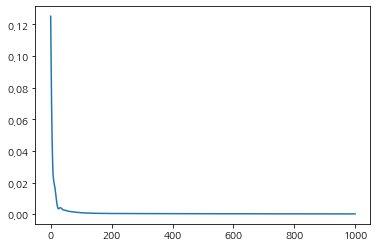

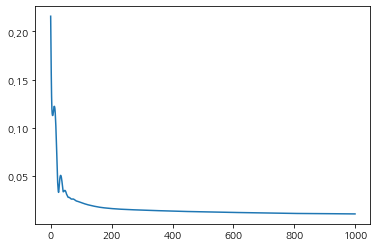

In [7]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist11.history['loss'])

_, axe = plt.subplots()
axe.plot(hist11.history['mae'])

1/1 [==============================] - 1s 1s/step
[[0.06865681]]


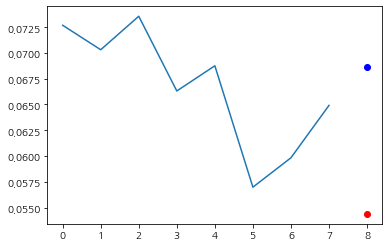

In [8]:
overland_2010_predict = model11.predict(overland_2010_x[1].reshape(1, 8, 1))
print(overland_2010_predict)

_, axe = plt.subplots()
axe.plot(overland_2010_x[1])
axe.scatter([8], overland_2010_y[1], c='r')
axe.scatter([8], overland_2010_predict, c='b')

In [9]:
## RNN모델 적용 ## ==> Dense 적용
model12 = keras.Sequential([
    keras.layers.SimpleRNN(16, input_shape=(None, 1)),
    keras.layers.Dense(1)
])

model12.compile(optimizer='adam', loss='mse', metrics='mae')
model12.summary()
hist12 = model12.fit(overland_2010_x, overland_2010_y, epochs=1000)
print(model12.evaluate(overland_2010_x, overland_2010_y))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 16)                288       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 1s 906ms/step - loss: 0.0291 - mae: 0.0737
Epoch 2/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0241 - mae: 0.0614
Epoch 3/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0203 - mae: 0.0576
Epoch 4/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.0175 - mae: 0.0629
Epoch 5/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0

1/1 [==============================] - 0s 9ms/step - loss: 7.7869e-04 - mae: 0.0178
Epoch 81/1000
1/1 [==============================] - 0s 7ms/step - loss: 7.5905e-04 - mae: 0.0175
Epoch 82/1000
1/1 [==============================] - 0s 7ms/step - loss: 7.4050e-04 - mae: 0.0174
Epoch 83/1000
1/1 [==============================] - 0s 7ms/step - loss: 7.2283e-04 - mae: 0.0172
Epoch 84/1000
1/1 [==============================] - 0s 7ms/step - loss: 7.0573e-04 - mae: 0.0171
Epoch 85/1000
1/1 [==============================] - 0s 7ms/step - loss: 6.8906e-04 - mae: 0.0169
Epoch 86/1000
1/1 [==============================] - 0s 8ms/step - loss: 6.7292e-04 - mae: 0.0168
Epoch 87/1000
1/1 [==============================] - 0s 8ms/step - loss: 6.5747e-04 - mae: 0.0167
Epoch 88/1000
1/1 [==============================] - 0s 7ms/step - loss: 6.4279e-04 - mae: 0.0165
Epoch 89/1000
1/1 [==============================] - 0s 7ms/step - loss: 6.2879e-04 - mae: 0.0164
Epoch 90/1000
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 3.7189e-04 - mae: 0.0126
Epoch 164/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.7156e-04 - mae: 0.0126
Epoch 165/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.7123e-04 - mae: 0.0126
Epoch 166/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.7090e-04 - mae: 0.0126
Epoch 167/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.7056e-04 - mae: 0.0125
Epoch 168/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.7023e-04 - mae: 0.0125
Epoch 169/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.6989e-04 - mae: 0.0125
Epoch 170/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.6956e-04 - mae: 0.0125
Epoch 171/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.6922e-04 - mae: 0.0125
Epoch 172/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.6889e-04 - mae: 0.0125
Epoch 173/1000
1/1 [====

1/1 [==============================] - 0s 7ms/step - loss: 3.4503e-04 - mae: 0.0123
Epoch 246/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.4472e-04 - mae: 0.0123
Epoch 247/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.4441e-04 - mae: 0.0123
Epoch 248/1000
1/1 [==============================] - 0s 10ms/step - loss: 3.4410e-04 - mae: 0.0123
Epoch 249/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.4379e-04 - mae: 0.0123
Epoch 250/1000
1/1 [==============================] - 0s 11ms/step - loss: 3.4348e-04 - mae: 0.0123
Epoch 251/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.4318e-04 - mae: 0.0123
Epoch 252/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.4287e-04 - mae: 0.0123
Epoch 253/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.4256e-04 - mae: 0.0122
Epoch 254/1000
1/1 [==============================] - 0s 6ms/step - loss: 3.4226e-04 - mae: 0.0122
Epoch 255/1000
1/1 [===

1/1 [==============================] - 0s 7ms/step - loss: 3.2241e-04 - mae: 0.0120
Epoch 328/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.2218e-04 - mae: 0.0120
Epoch 329/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.2195e-04 - mae: 0.0120
Epoch 330/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.2172e-04 - mae: 0.0120
Epoch 331/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.2148e-04 - mae: 0.0120
Epoch 332/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.2126e-04 - mae: 0.0120
Epoch 333/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.2103e-04 - mae: 0.0120
Epoch 334/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.2080e-04 - mae: 0.0120
Epoch 335/1000
1/1 [==============================] - 0s 10ms/step - loss: 3.2057e-04 - mae: 0.0120
Epoch 336/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.2035e-04 - mae: 0.0120
Epoch 337/1000
1/1 [====

1/1 [==============================] - 0s 9ms/step - loss: 3.0683e-04 - mae: 0.0119
Epoch 410/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.0668e-04 - mae: 0.0119
Epoch 411/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.0653e-04 - mae: 0.0119
Epoch 412/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.0638e-04 - mae: 0.0119
Epoch 413/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.0624e-04 - mae: 0.0119
Epoch 414/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.0609e-04 - mae: 0.0119
Epoch 415/1000
1/1 [==============================] - 0s 13ms/step - loss: 3.0595e-04 - mae: 0.0119
Epoch 416/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.0580e-04 - mae: 0.0119
Epoch 417/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.0566e-04 - mae: 0.0119
Epoch 418/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.0552e-04 - mae: 0.0119
Epoch 419/1000
1/1 [===

1/1 [==============================] - 0s 8ms/step - loss: 2.9685e-04 - mae: 0.0120
Epoch 492/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.9675e-04 - mae: 0.0120
Epoch 493/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.9665e-04 - mae: 0.0120
Epoch 494/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.9655e-04 - mae: 0.0120
Epoch 495/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.9645e-04 - mae: 0.0120
Epoch 496/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.9635e-04 - mae: 0.0120
Epoch 497/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.9625e-04 - mae: 0.0120
Epoch 498/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.9615e-04 - mae: 0.0120
Epoch 499/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.9605e-04 - mae: 0.0120
Epoch 500/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.9595e-04 - mae: 0.0120
Epoch 501/1000
1/1 [=====

1/1 [==============================] - 0s 11ms/step - loss: 2.8926e-04 - mae: 0.0120
Epoch 574/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.8917e-04 - mae: 0.0120
Epoch 575/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.8908e-04 - mae: 0.0120
Epoch 576/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.8900e-04 - mae: 0.0120
Epoch 577/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.8891e-04 - mae: 0.0120
Epoch 578/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.8882e-04 - mae: 0.0120
Epoch 579/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.8874e-04 - mae: 0.0120
Epoch 580/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.8865e-04 - mae: 0.0120
Epoch 581/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.8856e-04 - mae: 0.0120
Epoch 582/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.8848e-04 - mae: 0.0120
Epoch 583/1000
1/1 [

1/1 [==============================] - 0s 7ms/step - loss: 2.8228e-04 - mae: 0.0119
Epoch 656/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.8219e-04 - mae: 0.0119
Epoch 657/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.8211e-04 - mae: 0.0119
Epoch 658/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.8203e-04 - mae: 0.0119
Epoch 659/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.8194e-04 - mae: 0.0119
Epoch 660/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.8186e-04 - mae: 0.0119
Epoch 661/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.8178e-04 - mae: 0.0119
Epoch 662/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.8169e-04 - mae: 0.0119
Epoch 663/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.8161e-04 - mae: 0.0119
Epoch 664/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.8152e-04 - mae: 0.0119
Epoch 665/1000
1/1 [=====

1/1 [==============================] - 0s 7ms/step - loss: 2.7546e-04 - mae: 0.0119
Epoch 738/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.7538e-04 - mae: 0.0119
Epoch 739/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.7530e-04 - mae: 0.0119
Epoch 740/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.7521e-04 - mae: 0.0119
Epoch 741/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.7513e-04 - mae: 0.0119
Epoch 742/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.7505e-04 - mae: 0.0119
Epoch 743/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.7497e-04 - mae: 0.0119
Epoch 744/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.7488e-04 - mae: 0.0119
Epoch 745/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.7480e-04 - mae: 0.0119
Epoch 746/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.7472e-04 - mae: 0.0119
Epoch 747/1000
1/1 [=====

1/1 [==============================] - 0s 6ms/step - loss: 2.6874e-04 - mae: 0.0118
Epoch 820/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.6866e-04 - mae: 0.0118
Epoch 821/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.6857e-04 - mae: 0.0118
Epoch 822/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.6849e-04 - mae: 0.0118
Epoch 823/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.6841e-04 - mae: 0.0118
Epoch 824/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.6833e-04 - mae: 0.0118
Epoch 825/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.6825e-04 - mae: 0.0118
Epoch 826/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.6817e-04 - mae: 0.0118
Epoch 827/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.6809e-04 - mae: 0.0118
Epoch 828/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.6800e-04 - mae: 0.0118
Epoch 829/1000
1/1 [=====

1/1 [==============================] - 0s 6ms/step - loss: 2.6209e-04 - mae: 0.0118
Epoch 902/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.6201e-04 - mae: 0.0118
Epoch 903/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.6193e-04 - mae: 0.0118
Epoch 904/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.6185e-04 - mae: 0.0118
Epoch 905/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.6176e-04 - mae: 0.0118
Epoch 906/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.6168e-04 - mae: 0.0118
Epoch 907/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.6160e-04 - mae: 0.0118
Epoch 908/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.6152e-04 - mae: 0.0118
Epoch 909/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.6144e-04 - mae: 0.0118
Epoch 910/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.6136e-04 - mae: 0.0118
Epoch 911/1000
1/1 [=====

1/1 [==============================] - 0s 8ms/step - loss: 2.5548e-04 - mae: 0.0117
Epoch 984/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.5540e-04 - mae: 0.0117
Epoch 985/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.5532e-04 - mae: 0.0117
Epoch 986/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.5523e-04 - mae: 0.0117
Epoch 987/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.5515e-04 - mae: 0.0117
Epoch 988/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.5507e-04 - mae: 0.0117
Epoch 989/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.5499e-04 - mae: 0.0117
Epoch 990/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.5491e-04 - mae: 0.0117
Epoch 991/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.5483e-04 - mae: 0.0117
Epoch 992/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.5475e-04 - mae: 0.0117
Epoch 993/1000
1/1 [====

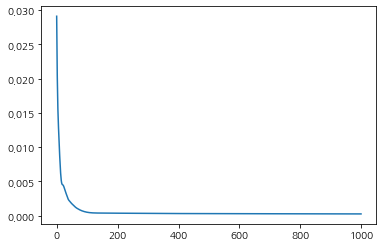

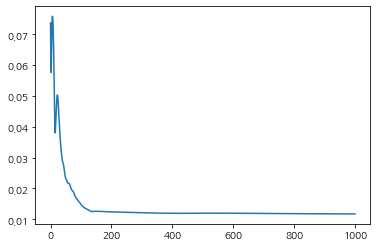

In [10]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist12.history['loss'])

_, axe = plt.subplots()
axe.plot(hist12.history['mae'])

1/1 [==============================] - 0s 149ms/step
[[0.06450692]]


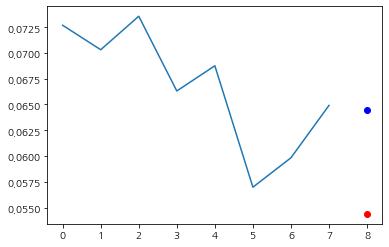

In [11]:
overland_2010_predict = model12.predict(overland_2010_x[1].reshape(1, 8, 1))
print(overland_2010_predict)

_, axe = plt.subplots()
axe.plot(overland_2010_x[1])
axe.scatter([8], overland_2010_y[1], c='r')
axe.scatter([8], overland_2010_predict, c='b')

1/1 [==============================] - 0s 24ms/step
[[0.02772363]]


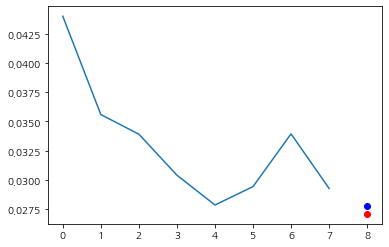

In [23]:
sample_n = 6  # 샘플 인덱스 변수화

overland_2010_predict = model12.predict(overland_2010_x[sample_n].reshape(1, 8, 1))
print(overland_2010_predict)

_, axe = plt.subplots()
axe.plot(overland_2010_x[sample_n])
axe.scatter([8], overland_2010_y[sample_n], c='r')
axe.scatter([8], overland_2010_predict, c='b')

In [24]:
x = overland_2010_search['시도별'].unique()

overland_2010 = []

for i in x:
    if i != '세종특별자치시' and i != '전국':
        filter1 = overland_2010_search['시도별'] == i
        data = overland_2010_search[filter1]

        filter2 = data['산업별'] == '육상운송 및 파이프라인 운송업'
        data_overland = data[filter2]
        data_overland.iloc[:,3:] = data_overland.iloc[:,3:].astype('int64')
        data_overland_numpy = data_overland['매출액 (백만원)'].to_numpy()
#         print(data_overland_numpy)
        overland_2010.append(data_overland_numpy)
         
overland_2010 = np.array(overland_2010)
print('overland_2010 : \n', overland_2010)

overland_2010_normalization = (overland_2010 - overland_2010.min())/(overland_2010.max() - overland_2010.min()) # 정규화한 데이터
print(overland_2010_normalization) 
print(overland_2010_normalization.shape)

# 정규화한 데이터
overland_2010_x = overland_2010_normalization[:, :-1]
overland_2010_x = overland_2010_x.reshape(16, 8, 1)

print('\n overland_2010_x : \n', overland_2010_x)

# 정규화한 데이터
overland_2010_y = overland_2010_normalization[:,-1]

print('\n overland_2010_y : \n', overland_2010_y)


overland_2010 : 
 [[  631455   612355   508391   524752   522800   502117   473797   447072
    464997]
 [ 2144435  2018173  1975033  1998247  2036131  2233791  1930745  2173370
   1847482]
 [ 2118141  2127405  2000987  1910933  1857879  2161708  1944247  2047020
   1907368]
 [ 1862420  1824561  1717379  1670960  1266404  1195893  1323302  1681022
   1326512]
 [ 1515888  1324035  1295257  1370625  1178886  1362043  1332763  1393273
   1477184]
 [ 1813494  1709709  1850271  1775838  1548630  1389244  1308345  1445164
   1577711]
 [ 1353806  1270539  1162883  1215609  1192864  1326331  1284514  1224449
   1088100]
 [ 1072900  1050376  1034696  1071605   984062   986599   932980   860908
    920400]
 [11643083 10439563 10141484 10124873  9208289  9275228 10275698 10637968
   8133400]
 [ 1405592  1314666  1351827  1132404  1193053   972646   951671   978982
    854442]
 [ 6642800  6413714  6386783  6631534  6354396  5932943  5787898  5352228
   5720449]
 [ 1416007  1335023  1749405  165229

In [25]:
## RNN모델 적용 ## ==> RNN 레이어 3단 적용
model13 = keras.Sequential([
    keras.layers.SimpleRNN(16, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model13.compile(optimizer='adam', loss='mse', metrics='mae')
model13.summary()
hist13 = model13.fit(overland_2010_x, overland_2010_y, epochs=1000)
print(model13.evaluate(overland_2010_x, overland_2010_y))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 16)          288       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, None, 8)           200       
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 1)                 10        
                                                                 
Total params: 498
Trainable params: 498
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0283 - mae: 0.0710
Epoch 2/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0206 - mae: 0.0671
Epoch 3/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0168 - mae: 0.0725
Epoch 4/1000
1/1 [======================

1/1 [==============================] - 0s 8ms/step - loss: 0.0010 - mae: 0.0211
Epoch 80/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0010 - mae: 0.0209
Epoch 81/1000
1/1 [==============================] - 0s 9ms/step - loss: 9.9463e-04 - mae: 0.0208
Epoch 82/1000
1/1 [==============================] - 0s 10ms/step - loss: 9.7875e-04 - mae: 0.0208
Epoch 83/1000
1/1 [==============================] - 0s 9ms/step - loss: 9.6402e-04 - mae: 0.0208
Epoch 84/1000
1/1 [==============================] - 0s 10ms/step - loss: 9.4990e-04 - mae: 0.0207
Epoch 85/1000
1/1 [==============================] - 0s 12ms/step - loss: 9.3570e-04 - mae: 0.0206
Epoch 86/1000
1/1 [==============================] - 0s 12ms/step - loss: 9.2142e-04 - mae: 0.0205
Epoch 87/1000
1/1 [==============================] - 0s 12ms/step - loss: 9.0755e-04 - mae: 0.0204
Epoch 88/1000
1/1 [==============================] - 0s 12ms/step - loss: 8.9430e-04 - mae: 0.0203
Epoch 89/1000
1/1 [================

1/1 [==============================] - 0s 12ms/step - loss: 3.0722e-04 - mae: 0.0134
Epoch 162/1000
1/1 [==============================] - 0s 12ms/step - loss: 3.0382e-04 - mae: 0.0133
Epoch 163/1000
1/1 [==============================] - 0s 13ms/step - loss: 3.0054e-04 - mae: 0.0133
Epoch 164/1000
1/1 [==============================] - 0s 14ms/step - loss: 2.9738e-04 - mae: 0.0132
Epoch 165/1000
1/1 [==============================] - 0s 13ms/step - loss: 2.9433e-04 - mae: 0.0132
Epoch 166/1000
1/1 [==============================] - 0s 12ms/step - loss: 2.9140e-04 - mae: 0.0131
Epoch 167/1000
1/1 [==============================] - 0s 13ms/step - loss: 2.8857e-04 - mae: 0.0130
Epoch 168/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.8586e-04 - mae: 0.0130
Epoch 169/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.8325e-04 - mae: 0.0129
Epoch 170/1000
1/1 [==============================] - 0s 11ms/step - loss: 2.8073e-04 - mae: 0.0129
Epoch 171/1000


1/1 [==============================] - 0s 11ms/step - loss: 2.1120e-04 - mae: 0.0109
Epoch 244/1000
1/1 [==============================] - 0s 11ms/step - loss: 2.1075e-04 - mae: 0.0109
Epoch 245/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.1029e-04 - mae: 0.0108
Epoch 246/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.0984e-04 - mae: 0.0108
Epoch 247/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.0940e-04 - mae: 0.0108
Epoch 248/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.0896e-04 - mae: 0.0108
Epoch 249/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.0852e-04 - mae: 0.0108
Epoch 250/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.0809e-04 - mae: 0.0107
Epoch 251/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.0767e-04 - mae: 0.0107
Epoch 252/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.0724e-04 - mae: 0.0107
Epoch 253/1000
1/1 [

1/1 [==============================] - 0s 11ms/step - loss: 1.8488e-04 - mae: 0.0097
Epoch 326/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.8466e-04 - mae: 0.0097
Epoch 327/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.8444e-04 - mae: 0.0097
Epoch 328/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.8422e-04 - mae: 0.0097
Epoch 329/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.8400e-04 - mae: 0.0097
Epoch 330/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.8378e-04 - mae: 0.0097
Epoch 331/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.8356e-04 - mae: 0.0097
Epoch 332/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.8335e-04 - mae: 0.0097
Epoch 333/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.8314e-04 - mae: 0.0097
Epoch 334/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.8293e-04 - mae: 0.0096
Epoch 335/1000
1/1

1/1 [==============================] - 0s 10ms/step - loss: 1.7001e-04 - mae: 0.0091
Epoch 408/1000
1/1 [==============================] - 0s 12ms/step - loss: 1.6985e-04 - mae: 0.0091
Epoch 409/1000
1/1 [==============================] - 0s 22ms/step - loss: 1.6970e-04 - mae: 0.0091
Epoch 410/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.6954e-04 - mae: 0.0091
Epoch 411/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.6939e-04 - mae: 0.0091
Epoch 412/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.6923e-04 - mae: 0.0091
Epoch 413/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.6908e-04 - mae: 0.0091
Epoch 414/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.6893e-04 - mae: 0.0091
Epoch 415/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.6878e-04 - mae: 0.0091
Epoch 416/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.6862e-04 - mae: 0.0091
Epoch 417/1000
1

1/1 [==============================] - 0s 8ms/step - loss: 1.5764e-04 - mae: 0.0088
Epoch 490/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.5749e-04 - mae: 0.0088
Epoch 491/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.5733e-04 - mae: 0.0088
Epoch 492/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.5718e-04 - mae: 0.0088
Epoch 493/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.5702e-04 - mae: 0.0088
Epoch 494/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.5687e-04 - mae: 0.0088
Epoch 495/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.5671e-04 - mae: 0.0087
Epoch 496/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.5656e-04 - mae: 0.0087
Epoch 497/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.5640e-04 - mae: 0.0087
Epoch 498/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.5625e-04 - mae: 0.0087
Epoch 499/1000
1/1 [====

1/1 [==============================] - 0s 13ms/step - loss: 1.4384e-04 - mae: 0.0084
Epoch 572/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.4366e-04 - mae: 0.0084
Epoch 573/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.4347e-04 - mae: 0.0084
Epoch 574/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.4328e-04 - mae: 0.0083
Epoch 575/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.4309e-04 - mae: 0.0083
Epoch 576/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.4290e-04 - mae: 0.0083
Epoch 577/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.4271e-04 - mae: 0.0083
Epoch 578/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.4251e-04 - mae: 0.0083
Epoch 579/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.4232e-04 - mae: 0.0083
Epoch 580/1000
1/1 [==============================] - 0s 12ms/step - loss: 1.4213e-04 - mae: 0.0083
Epoch 581/1000
1

1/1 [==============================] - 0s 13ms/step - loss: 1.2620e-04 - mae: 0.0078
Epoch 654/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.2596e-04 - mae: 0.0078
Epoch 655/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.2571e-04 - mae: 0.0078
Epoch 656/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.2547e-04 - mae: 0.0077
Epoch 657/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.2522e-04 - mae: 0.0077
Epoch 658/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.2498e-04 - mae: 0.0077
Epoch 659/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.2473e-04 - mae: 0.0077
Epoch 660/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.2448e-04 - mae: 0.0077
Epoch 661/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.2423e-04 - mae: 0.0077
Epoch 662/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.2399e-04 - mae: 0.0077
Epoch 663/1000
1

1/1 [==============================] - 0s 9ms/step - loss: 1.0493e-04 - mae: 0.0071
Epoch 736/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0467e-04 - mae: 0.0071
Epoch 737/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.0441e-04 - mae: 0.0071
Epoch 738/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.0415e-04 - mae: 0.0071
Epoch 739/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.0389e-04 - mae: 0.0071
Epoch 740/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.0363e-04 - mae: 0.0071
Epoch 741/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.0338e-04 - mae: 0.0071
Epoch 742/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.0312e-04 - mae: 0.0071
Epoch 743/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.0286e-04 - mae: 0.0071
Epoch 744/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.0260e-04 - mae: 0.0071
Epoch 745/1000
1/1 

1/1 [==============================] - 0s 12ms/step - loss: 8.6477e-05 - mae: 0.0071
Epoch 818/1000
1/1 [==============================] - 0s 12ms/step - loss: 8.6299e-05 - mae: 0.0071
Epoch 819/1000
1/1 [==============================] - 0s 17ms/step - loss: 8.6124e-05 - mae: 0.0071
Epoch 820/1000
1/1 [==============================] - 0s 12ms/step - loss: 8.5950e-05 - mae: 0.0071
Epoch 821/1000
1/1 [==============================] - 0s 10ms/step - loss: 8.5775e-05 - mae: 0.0071
Epoch 822/1000
1/1 [==============================] - 0s 9ms/step - loss: 8.5604e-05 - mae: 0.0071
Epoch 823/1000
1/1 [==============================] - 0s 9ms/step - loss: 8.5433e-05 - mae: 0.0071
Epoch 824/1000
1/1 [==============================] - 0s 10ms/step - loss: 8.5262e-05 - mae: 0.0071
Epoch 825/1000
1/1 [==============================] - 0s 12ms/step - loss: 8.5094e-05 - mae: 0.0071
Epoch 826/1000
1/1 [==============================] - 0s 13ms/step - loss: 8.4927e-05 - mae: 0.0071
Epoch 827/1000
1/

1/1 [==============================] - 0s 10ms/step - loss: 7.5181e-05 - mae: 0.0069
Epoch 900/1000
1/1 [==============================] - 0s 10ms/step - loss: 7.5071e-05 - mae: 0.0069
Epoch 901/1000
1/1 [==============================] - 0s 9ms/step - loss: 7.4961e-05 - mae: 0.0069
Epoch 902/1000
1/1 [==============================] - 0s 9ms/step - loss: 7.4852e-05 - mae: 0.0069
Epoch 903/1000
1/1 [==============================] - 0s 10ms/step - loss: 7.4745e-05 - mae: 0.0069
Epoch 904/1000
1/1 [==============================] - 0s 9ms/step - loss: 7.4637e-05 - mae: 0.0069
Epoch 905/1000
1/1 [==============================] - 0s 11ms/step - loss: 7.4529e-05 - mae: 0.0069
Epoch 906/1000
1/1 [==============================] - 0s 11ms/step - loss: 7.4422e-05 - mae: 0.0069
Epoch 907/1000
1/1 [==============================] - 0s 13ms/step - loss: 7.4317e-05 - mae: 0.0069
Epoch 908/1000
1/1 [==============================] - 0s 11ms/step - loss: 7.4209e-05 - mae: 0.0068
Epoch 909/1000
1/1

1/1 [==============================] - 0s 12ms/step - loss: 6.7129e-05 - mae: 0.0065
Epoch 982/1000
1/1 [==============================] - 0s 11ms/step - loss: 6.7039e-05 - mae: 0.0065
Epoch 983/1000
1/1 [==============================] - 0s 13ms/step - loss: 6.6949e-05 - mae: 0.0065
Epoch 984/1000
1/1 [==============================] - 0s 12ms/step - loss: 6.6859e-05 - mae: 0.0065
Epoch 985/1000
1/1 [==============================] - 0s 11ms/step - loss: 6.6768e-05 - mae: 0.0065
Epoch 986/1000
1/1 [==============================] - 0s 14ms/step - loss: 6.6678e-05 - mae: 0.0065
Epoch 987/1000
1/1 [==============================] - 0s 11ms/step - loss: 6.6589e-05 - mae: 0.0065
Epoch 988/1000
1/1 [==============================] - 0s 11ms/step - loss: 6.6499e-05 - mae: 0.0065
Epoch 989/1000
1/1 [==============================] - 0s 11ms/step - loss: 6.6410e-05 - mae: 0.0065
Epoch 990/1000
1/1 [==============================] - 0s 14ms/step - loss: 6.6322e-05 - mae: 0.0065
Epoch 991/1000


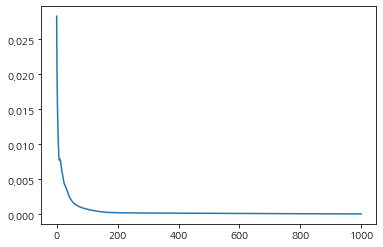

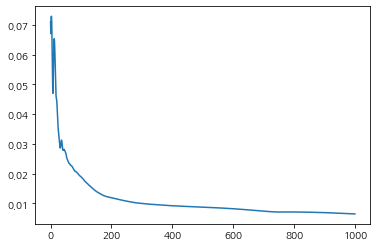

In [26]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist13.history['loss'])

_, axe = plt.subplots()
axe.plot(hist13.history['mae'])

1/1 [==============================] - 0s 365ms/step
[[0.07140835]]


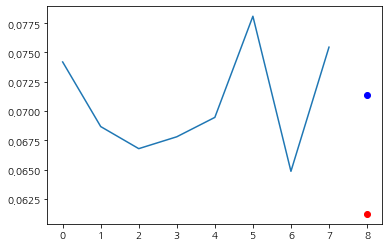

In [27]:
overland_2010_predict = model13.predict(overland_2010_x[1].reshape(1, 8, 1))
print(overland_2010_predict)

_, axe = plt.subplots()
axe.plot(overland_2010_x[1])
axe.scatter([8], overland_2010_y[1], c='r')
axe.scatter([8], overland_2010_predict, c='b')

In [28]:
## RNN모델 적용 ## ==> Dense 적용
model14 = keras.Sequential([
    keras.layers.SimpleRNN(16, input_shape=(None, 1)),
    keras.layers.Dense(1)
])

model14.compile(optimizer='adam', loss='mse', metrics='mae')
model14.summary()
hist14 = model14.fit(overland_2010_x, overland_2010_y, epochs=1000)
print(model14.evaluate(overland_2010_x, overland_2010_y))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 16)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 1s 866ms/step - loss: 0.0201 - mae: 0.0519
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0162 - mae: 0.0560
Epoch 3/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0135 - mae: 0.0606
Epoch 4/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0113 - mae: 0.0616
Epoch 5/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0094

1/1 [==============================] - 0s 6ms/step - loss: 6.4610e-04 - mae: 0.0167
Epoch 80/1000
1/1 [==============================] - 0s 6ms/step - loss: 6.3739e-04 - mae: 0.0166
Epoch 81/1000
1/1 [==============================] - 0s 7ms/step - loss: 6.2899e-04 - mae: 0.0165
Epoch 82/1000
1/1 [==============================] - 0s 8ms/step - loss: 6.2105e-04 - mae: 0.0163
Epoch 83/1000
1/1 [==============================] - 0s 9ms/step - loss: 6.1358e-04 - mae: 0.0162
Epoch 84/1000
1/1 [==============================] - 0s 6ms/step - loss: 6.0645e-04 - mae: 0.0161
Epoch 85/1000
1/1 [==============================] - 0s 6ms/step - loss: 5.9953e-04 - mae: 0.0160
Epoch 86/1000
1/1 [==============================] - 0s 7ms/step - loss: 5.9276e-04 - mae: 0.0159
Epoch 87/1000
1/1 [==============================] - 0s 8ms/step - loss: 5.8614e-04 - mae: 0.0158
Epoch 88/1000
1/1 [==============================] - 0s 8ms/step - loss: 5.7969e-04 - mae: 0.0158
Epoch 89/1000
1/1 [===============

1/1 [==============================] - 0s 7ms/step - loss: 3.4748e-04 - mae: 0.0121
Epoch 163/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.4614e-04 - mae: 0.0121
Epoch 164/1000
1/1 [==============================] - 0s 6ms/step - loss: 3.4482e-04 - mae: 0.0121
Epoch 165/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.4353e-04 - mae: 0.0120
Epoch 166/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.4226e-04 - mae: 0.0120
Epoch 167/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.4102e-04 - mae: 0.0120
Epoch 168/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.3980e-04 - mae: 0.0120
Epoch 169/1000
1/1 [==============================] - 0s 8ms/step - loss: 3.3860e-04 - mae: 0.0119
Epoch 170/1000
1/1 [==============================] - 0s 9ms/step - loss: 3.3743e-04 - mae: 0.0119
Epoch 171/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.3627e-04 - mae: 0.0119
Epoch 172/1000
1/1 [=====

1/1 [==============================] - 0s 6ms/step - loss: 2.9171e-04 - mae: 0.0107
Epoch 245/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.9143e-04 - mae: 0.0106
Epoch 246/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.9115e-04 - mae: 0.0106
Epoch 247/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.9088e-04 - mae: 0.0106
Epoch 248/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.9061e-04 - mae: 0.0106
Epoch 249/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.9034e-04 - mae: 0.0106
Epoch 250/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.9008e-04 - mae: 0.0106
Epoch 251/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.8983e-04 - mae: 0.0106
Epoch 252/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.8958e-04 - mae: 0.0106
Epoch 253/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.8933e-04 - mae: 0.0106
Epoch 254/1000
1/1 [=====

1/1 [==============================] - 0s 6ms/step - loss: 2.7683e-04 - mae: 0.0101
Epoch 327/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.7670e-04 - mae: 0.0101
Epoch 328/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.7656e-04 - mae: 0.0101
Epoch 329/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.7643e-04 - mae: 0.0101
Epoch 330/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.7629e-04 - mae: 0.0101
Epoch 331/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.7616e-04 - mae: 0.0101
Epoch 332/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.7602e-04 - mae: 0.0101
Epoch 333/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.7589e-04 - mae: 0.0101
Epoch 334/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.7576e-04 - mae: 0.0101
Epoch 335/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.7562e-04 - mae: 0.0101
Epoch 336/1000
1/1 [====

1/1 [==============================] - 0s 7ms/step - loss: 2.6635e-04 - mae: 0.0100
Epoch 409/1000
1/1 [==============================] - 0s 12ms/step - loss: 2.6623e-04 - mae: 0.0100
Epoch 410/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.6611e-04 - mae: 0.0100
Epoch 411/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.6598e-04 - mae: 0.0100
Epoch 412/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.6586e-04 - mae: 0.0100
Epoch 413/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.6574e-04 - mae: 0.0100
Epoch 414/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.6562e-04 - mae: 0.0100
Epoch 415/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.6549e-04 - mae: 0.0100
Epoch 416/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.6537e-04 - mae: 0.0100
Epoch 417/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.6525e-04 - mae: 0.0100
Epoch 418/1000
1/1 [===

1/1 [==============================] - 0s 6ms/step - loss: 2.5660e-04 - mae: 0.0099
Epoch 491/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.5648e-04 - mae: 0.0099
Epoch 492/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.5637e-04 - mae: 0.0099
Epoch 493/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.5625e-04 - mae: 0.0099
Epoch 494/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.5614e-04 - mae: 0.0099
Epoch 495/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.5602e-04 - mae: 0.0099
Epoch 496/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.5591e-04 - mae: 0.0099
Epoch 497/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.5580e-04 - mae: 0.0099
Epoch 498/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.5568e-04 - mae: 0.0099
Epoch 499/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.5557e-04 - mae: 0.0099
Epoch 500/1000
1/1 [=====

1/1 [==============================] - 0s 7ms/step - loss: 2.4752e-04 - mae: 0.0097
Epoch 573/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.4742e-04 - mae: 0.0097
Epoch 574/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.4731e-04 - mae: 0.0097
Epoch 575/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.4721e-04 - mae: 0.0097
Epoch 576/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.4710e-04 - mae: 0.0097
Epoch 577/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.4699e-04 - mae: 0.0097
Epoch 578/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.4689e-04 - mae: 0.0097
Epoch 579/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.4678e-04 - mae: 0.0097
Epoch 580/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.4667e-04 - mae: 0.0097
Epoch 581/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.4657e-04 - mae: 0.0097
Epoch 582/1000
1/1 [=====

1/1 [==============================] - 0s 7ms/step - loss: 2.3911e-04 - mae: 0.0096
Epoch 655/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.3901e-04 - mae: 0.0096
Epoch 656/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.3891e-04 - mae: 0.0096
Epoch 657/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.3881e-04 - mae: 0.0096
Epoch 658/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.3871e-04 - mae: 0.0096
Epoch 659/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.3861e-04 - mae: 0.0096
Epoch 660/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.3851e-04 - mae: 0.0096
Epoch 661/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.3841e-04 - mae: 0.0096
Epoch 662/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.3832e-04 - mae: 0.0096
Epoch 663/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.3822e-04 - mae: 0.0096
Epoch 664/1000
1/1 [=====

1/1 [==============================] - 0s 10ms/step - loss: 2.3126e-04 - mae: 0.0094
Epoch 737/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.3116e-04 - mae: 0.0094
Epoch 738/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.3107e-04 - mae: 0.0094
Epoch 739/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.3098e-04 - mae: 0.0094
Epoch 740/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.3089e-04 - mae: 0.0094
Epoch 741/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.3079e-04 - mae: 0.0094
Epoch 742/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.3070e-04 - mae: 0.0094
Epoch 743/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.3061e-04 - mae: 0.0094
Epoch 744/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.3052e-04 - mae: 0.0094
Epoch 745/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.3042e-04 - mae: 0.0094
Epoch 746/1000
1/1 [====

1/1 [==============================] - 0s 7ms/step - loss: 2.2386e-04 - mae: 0.0093
Epoch 819/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.2377e-04 - mae: 0.0093
Epoch 820/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.2369e-04 - mae: 0.0093
Epoch 821/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.2360e-04 - mae: 0.0093
Epoch 822/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.2351e-04 - mae: 0.0093
Epoch 823/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.2342e-04 - mae: 0.0093
Epoch 824/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.2334e-04 - mae: 0.0093
Epoch 825/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.2325e-04 - mae: 0.0093
Epoch 826/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.2316e-04 - mae: 0.0093
Epoch 827/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.2307e-04 - mae: 0.0093
Epoch 828/1000
1/1 [=====

1/1 [==============================] - 0s 9ms/step - loss: 2.1680e-04 - mae: 0.0092
Epoch 901/1000
1/1 [==============================] - 0s 10ms/step - loss: 2.1672e-04 - mae: 0.0092
Epoch 902/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.1663e-04 - mae: 0.0092
Epoch 903/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.1655e-04 - mae: 0.0092
Epoch 904/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.1646e-04 - mae: 0.0092
Epoch 905/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.1638e-04 - mae: 0.0092
Epoch 906/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.1630e-04 - mae: 0.0092
Epoch 907/1000
1/1 [==============================] - 0s 9ms/step - loss: 2.1621e-04 - mae: 0.0092
Epoch 908/1000
1/1 [==============================] - 0s 11ms/step - loss: 2.1613e-04 - mae: 0.0092
Epoch 909/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.1604e-04 - mae: 0.0092
Epoch 910/1000
1/1 [===

1/1 [==============================] - 0s 7ms/step - loss: 2.0993e-04 - mae: 0.0091
Epoch 983/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.0984e-04 - mae: 0.0091
Epoch 984/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.0976e-04 - mae: 0.0091
Epoch 985/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.0968e-04 - mae: 0.0091
Epoch 986/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.0959e-04 - mae: 0.0091
Epoch 987/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.0951e-04 - mae: 0.0091
Epoch 988/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.0943e-04 - mae: 0.0091
Epoch 989/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.0934e-04 - mae: 0.0091
Epoch 990/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.0926e-04 - mae: 0.0091
Epoch 991/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.0918e-04 - mae: 0.0091
Epoch 992/1000
1/1 [=====

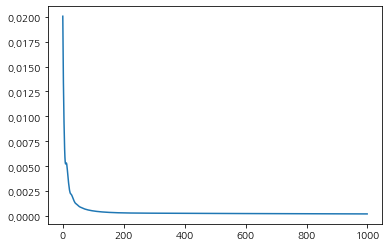

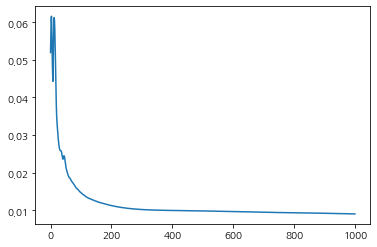

In [30]:
# loss, mae
_, axe = plt.subplots()
axe.plot(hist14.history['loss'])

_, axe = plt.subplots()
axe.plot(hist14.history['mae'])

1/1 [==============================] - 0s 122ms/step
[[0.0650901]]


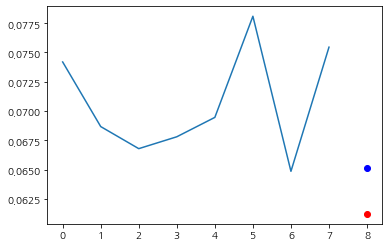

In [31]:
overland_2010_predict = model14.predict(overland_2010_x[1].reshape(1, 8, 1))
print(overland_2010_predict)

_, axe = plt.subplots()
axe.plot(overland_2010_x[1])
axe.scatter([8], overland_2010_y[1], c='r')
axe.scatter([8], overland_2010_predict, c='b')

1/1 [==============================] - 0s 30ms/step
[[0.22771856]]


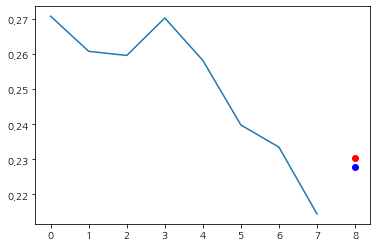

In [59]:
sample_n = 10 # 샘플 인덱스 변수화

overland_2010_predict = model14.predict(overland_2010_x[sample_n].reshape(1, 8, 1))
print(overland_2010_predict)

_, axe = plt.subplots()
axe.plot(overland_2010_x[sample_n])
axe.scatter([8], overland_2010_y[sample_n], c='r')
axe.scatter([8], overland_2010_predict, c='b')